<a href="https://colab.research.google.com/github/LeszekWawi/BoneMarrowCellClassifier/blob/main/BoneMarrowClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import zipfile
!apt install unzip
import albumentations
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,DepthwiseConv2D,Activation,Add
import random
import math
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, classification_report
!pip install lime
from lime import lime_image
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import mark_boundaries
!pip install zipfile
import zipfile
from tensorflow.keras.models import load_model
import json
import pickle
import PIL
import requests
import json

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
### values constant throught the code
Img_res=(224, 224)
Batch_size=64
Epochs=100
num_classes=8



In [8]:
### extract zipped image files 
with zipfile.ZipFile('/content/drive/MyDrive/BoneData/Dataset (2).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/nowy')

In [9]:
### getting the images as DataFrame

def get_df_data(image_path):
    images_file = []
    for (dirname, subdirs, filenames) in os.walk(image_path):
        full_filenames = [os.path.join(dirname, f) for f in filenames]
        file_name = [f for f in filenames]
        label = [f[:3] for f in filenames]
        images_file.append(full_filenames)
        

        dane = pd.DataFrame(full_filenames, columns=['image_path'])

        dane['label'] = label
        dane['label'] = dane['label'].astype('str')
        dane['file_name'] = file_name
        return dane

    
dane=get_df_data('/content/sample_data/nowy/Dataset')

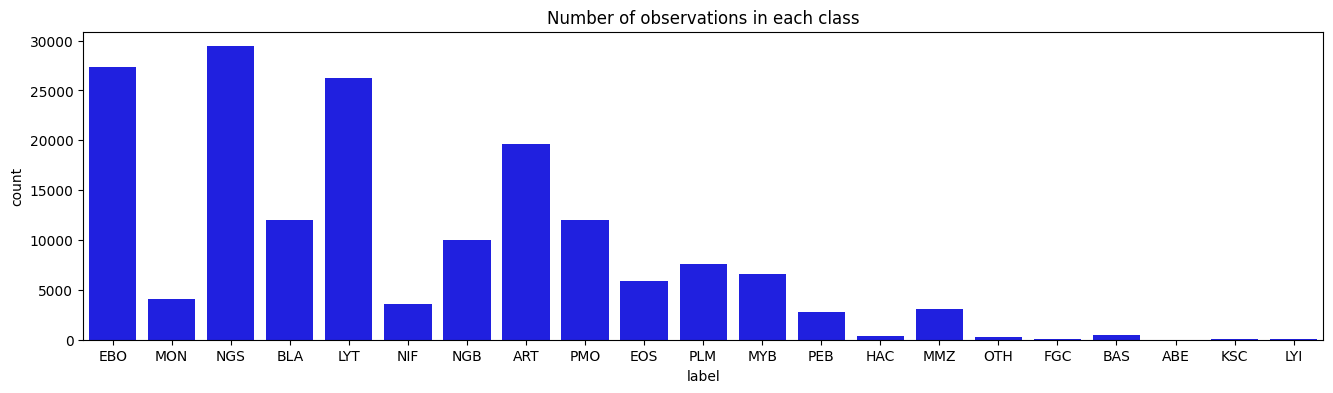

In [10]:
###visualization of the size of each class
plt.figure(figsize=(16, 4))
plt.title("Number of observations in each class")
sns.countplot(x=dane['label'],color='b')
plt.savefig('/content/drive/MyDrive/class_count.png')

In [11]:
### reduction extremelly low-count classes
unique_labels = dane['label'].unique()
temp_df = pd.DataFrame()
data_df=pd.DataFrame()

for label in unique_labels:
    label_df = dane[dane['label'] == label]
    if len(label_df) >= 0.04 * len(dane):
        data_df=pd.concat([data_df,label_df])    
    else:
        pass

data_df.head(3)
label_cat=data_df['label'].unique().tolist() #categorical data labels
class_dict=dict(enumerate(label_cat)) # 


In [42]:
class_dict

{0: 'EBO',
 1: 'NGS',
 2: 'BLA',
 3: 'LYT',
 4: 'NGB',
 5: 'ART',
 6: 'PMO',
 7: 'PLM'}

In [12]:
data_df.head()

,image_path,label,file_name
0,/content/sample_data/nowy/Dataset/EBO_01006.jpg,EBO,EBO_01006.jpg
3,/content/sample_data/nowy/Dataset/EBO_27093.jpg,EBO,EBO_27093.jpg
7,/content/sample_data/nowy/Dataset/EBO_26253.jpg,EBO,EBO_26253.jpg
10,/content/sample_data/nowy/Dataset/EBO_10685.jpg,EBO,EBO_10685.jpg
32,/content/sample_data/nowy/Dataset/EBO_13063.jpg,EBO,EBO_13063.jpg


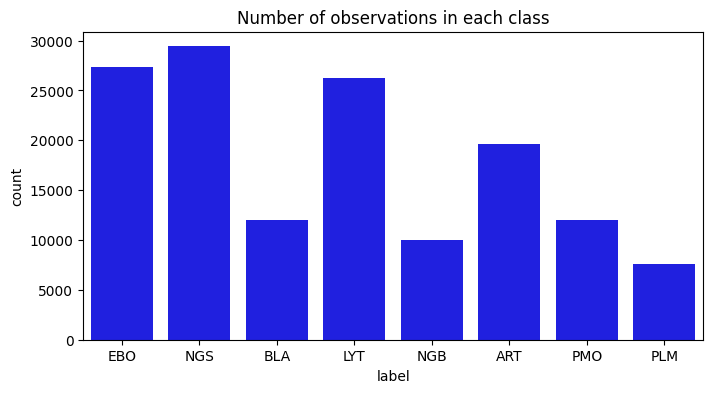

In [13]:
###visualization of the size of each class after class cut-off
plt.figure(figsize=(8, 4))
plt.title("Number of observations in each class")
sns.countplot(x=data_df['label'],color='b')
plt.savefig('/content/drive/MyDrive/red_class_count.png')

In [14]:
#one hot encoding of 8 categirical label classes
# 1. Encode the label using LabelEncoder
le = LabelEncoder()
data_df['label_enc']=le.fit_transform(data_df['label'])
num_classes = 8
le = LabelEncoder()
# Convert the encoded target variable to one-hot encoded format
target_encoded = le.fit_transform(data_df['label'])
one_hot_targets = tf.keras.utils.to_categorical(target_encoded, num_classes=num_classes)
# Create a new column in the DataFrame with the one-hot encoded labels
data_df['target'] = one_hot_targets.astype(np.int32).tolist()

In [15]:
data_df.head()

,image_path,label,file_name,label_enc,target
0,/content/sample_data/nowy/Dataset/EBO_01006.jpg,EBO,EBO_01006.jpg,2,"[0, 0, 1, 0, 0, 0, 0, 0]"
3,/content/sample_data/nowy/Dataset/EBO_27093.jpg,EBO,EBO_27093.jpg,2,"[0, 0, 1, 0, 0, 0, 0, 0]"
7,/content/sample_data/nowy/Dataset/EBO_26253.jpg,EBO,EBO_26253.jpg,2,"[0, 0, 1, 0, 0, 0, 0, 0]"
10,/content/sample_data/nowy/Dataset/EBO_10685.jpg,EBO,EBO_10685.jpg,2,"[0, 0, 1, 0, 0, 0, 0, 0]"
32,/content/sample_data/nowy/Dataset/EBO_13063.jpg,EBO,EBO_13063.jpg,2,"[0, 0, 1, 0, 0, 0, 0, 0]"


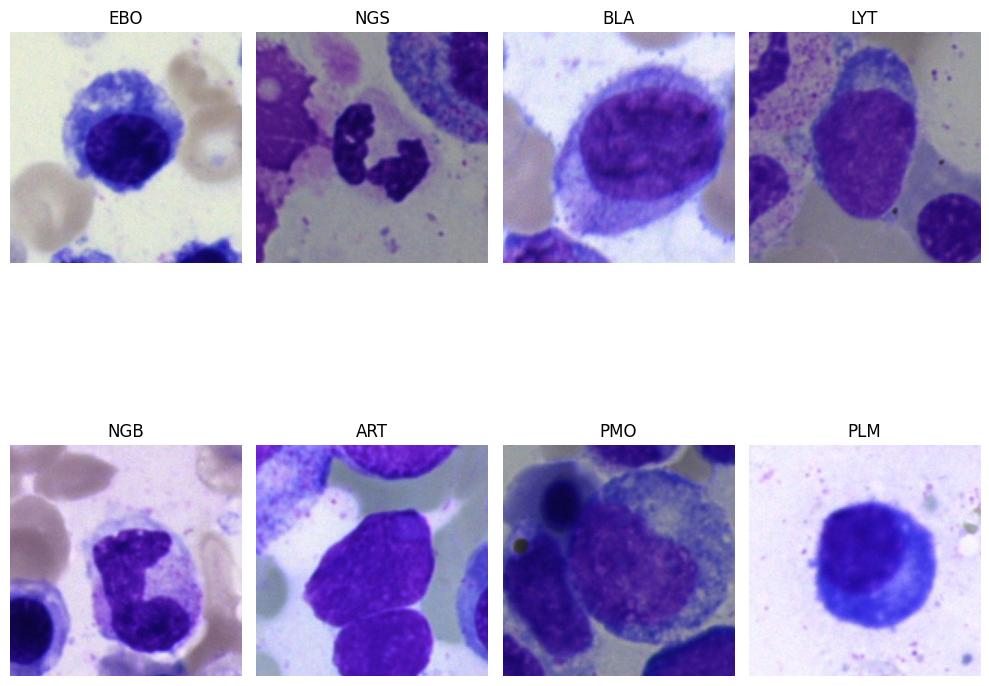

In [17]:
###examplary images from each class
def vis(df):
    num_cols=4
    num_rows=2  
    num_samples_per_class = 1 
    label_unique = data_df['label'].unique()[:num_classes]
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 10)) 

    for i, label in enumerate(label_unique):
        label_data = dane[dane['label'] == label]
        sampled_data = label_data.sample(num_samples_per_class, replace=False)

        row_idx = i // num_cols  
        col_idx = i % num_cols   

        for j, (_, row) in enumerate(sampled_data.iterrows()):
            image = cv2.imread(row['image_path'])
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        
            ax[row_idx, col_idx].imshow(image_rgb)
            ax[row_idx, col_idx].set_title(label)
            ax[row_idx, col_idx].axis('off')
       
    plt.tight_layout()
plt.show()
vis(data_df)
# plt.savefig('/content/drive/MyDrive/example_images.png')

In [18]:
#generator for dataset 
def get_generator(df):
    def generator():
        for _, row in df.iterrows():
            label = row['target']
            image = cv2.imread(row['image_path'])
            image_resized = cv2.resize(image, Img_res)
            image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB) / 255.
            yield image_rgb,label
    return generator

In [19]:
### generation of training,validation and test datasets using dataset generator 
def get_data():
    train_df, test_df = train_test_split(data_df, test_size=0.1,random_state=42,stratify=data_df['target'])
    train_df, val_df = train_test_split(train_df, test_size=0.1,random_state=42,stratify=train_df['target'])

    output_signature = (tf.TensorSpec((*Img_res, 3), dtype=tf.float32), tf.TensorSpec((8,), dtype=tf.int32))

    train_ds = tf.data.Dataset.from_generator(
        get_generator(train_df),
        output_signature=output_signature
    )
    train_ds = train_ds.shuffle(100)
    train_ds = train_ds.batch(Batch_size)
    train_ds=train_ds.repeat()

    val_ds = tf.data.Dataset.from_generator(
        get_generator(val_df),
        output_signature=output_signature)
    val_ds = val_ds.batch(Batch_size)

    test_ds = tf.data.Dataset.from_generator(
        get_generator(test_df),
        output_signature=output_signature)
    test_ds = test_ds.batch(Batch_size)
    
    

    return train_ds,val_ds,test_ds

In [20]:
### generation of train,validation and test datasets
train_ds,val_ds,test_ds=get_data()

In [21]:
# ### base model od CNN

model= tf.keras.models.Sequential([ tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape = (*Img_res,3)),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    # tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(8, activation ='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 128)     147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 216, 216, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 128)    0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 106, 106, 256)     295168    
                                                        

In [22]:
# ### Dropuot layer implemented into base model

model_Drop=tf.keras.models.Sequential([ tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape = (*Img_res,3)),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
                                    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(rate=0.3),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(8, activation ='softmax')])
model_Drop.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 conv2d_15 (Conv2D)          (None, 220, 220, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 128)    0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 108, 108, 256)     295168    
                                                                 
 conv2d_17 (Conv2D)          (None, 106, 106, 256)     590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 104, 104, 256)     590080    
                                                      

In [23]:
 ### implementing inverted_residual_blocks into the architecture
input_layer = tf.keras.layers.Input(shape=(*Img_res, 3))
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(input_layer)

init_model = x
x = Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(x) 
x = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, init_model])

init_model_=x
x = Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
x = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([x, init_model_])

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x= tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x= tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x=  tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(512, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.Conv2D(1024, (3, 3), activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dropout(rate=0.3)(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.Dense(256, activation='relu')(x)
x=tf.keras.layers.Dense(64, activation='relu')(x)
x=tf.keras.layers.Dense(8, activation='softmax')(x)

model_IRB=tf.keras.Model(inputs=input_layer, outputs=x)


model_IRB.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 222, 222, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 222, 222, 12  16512       ['conv2d_26[0][0]']              
                                8)                                                            

In [24]:
### custom callbacks- saving training chackpoint (useful in working at colab and risk of occasional venv corruption)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoints/model_Drop_checkpoint.h5',  
    save_weights_only=True,      
    save_best_only=True,         
    monitor='val_accuracy',          
    verbose=1                     
)
# early stopping
Early_Stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [25]:
### model compilation
model_IRB.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
callbacks =[ Early_Stopping,checkpoint_callback]
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
### model training
# history = model_IRB.fit(train_ds, validation_data=val_ds, batch_size=Batch_size,epochs=Epochs, steps_per_epoch=200,callbacks=callbacks)

In [26]:
### examination of the course of training: plotting accuracy and loss throughout training
def plot_epochs_acc_loss(history_list):
    acc = history_list.history['accuracy']
    val_acc = history_list.history['val_accuracy']
    loss = history_list.history['loss']
    val_loss = history_list.history['val_loss']
    epochs = np.arange(1, len(acc)+1)

    fig = plt.figure(figsize=(16, 6))
    # Accuracy
    fig.add_subplot(211)
    plt.plot(epochs, acc, color='green', label='Train')
    plt.plot(epochs, val_acc, color='red', label='Validation')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.xlim(epochs.min(), epochs.max())

    # Loss
    fig.add_subplot(212)
    plt.plot(epochs, loss, color='green', label='Train')
    plt.plot(epochs, val_loss, color='red', label='Validation')
    plt.legend(loc='lower right')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.xlim(epochs.min(), epochs.max())

    plt.show()

In [ ]:
plot_epochs_acc_loss(history)

In [33]:
### restoring weights from the "best" checkpoint for each model
model.load_weights('/content/drive/MyDrive/checkpoints/model_checkpoint.h5')
# model_Drop.load_weights('/content/drive/MyDrive/checkpoints/model_Drop_checkpoint.h5')
# model_IRB.load_weights('/content/drive/MyDrive/checkpoints/model_IRB_checkpoint.h5')

In [34]:
model_path = '/content/drive/MyDrive/checkpoints/model.h5'
# model_IRB_red_path='/content/drive/MyDrive/checkpoints/model_IRB_red.h5'
# model_Drop_path='/content/drive/MyDrive/checkpoints/model_Drop.h5'
# Save the model
model.save(model_path)
# model_IRB.save(model_IRB_red_path)
#model_Drop.save(model_Drop_path)

In [35]:
### Loading saved model
model_path='/content/drive/MyDrive/checkpoints/model.h5'
loaded_model = load_model(model_path)

In [113]:
loss,accuracy=loaded_model.evaluate(test_ds)

In [ ]:
### model evaluation at test dataset
# loss,accuracy=model_IRB.evaluate(test_ds)

In [112]:
# ### model prediction of the test data
pred=loaded_model.predict(
    test_ds)

In [37]:
def visualize_cm(dataset,model):
        test_labels = []
        test_labels_=[]
        tests=[]
        preds_=[]
        for features, labels in dataset:
            test_labels.append(np.array(labels))
        for i in range(len(test_labels)):
            test_labels_.append(test_labels[i])
            for j in range(len(test_labels[i])):
                tests.append(np.argmax(test_labels[i][j]))
        for k in range(len(pred)):
            preds_.append(np.argmax(pred[k]))

        cm=tf.math.confusion_matrix(
            tests,
            preds_,
            num_classes=8)
        fig,ax=plt.subplots(figsize=(8,8))
        classes=list(class_dict.values())
        sns.heatmap(cm,annot=True,cbar=True,fmt='d',xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted class')
        plt.ylabel('Ground truth')
        ax.tick_params(axis='x', bottom=False, labelbottom=True)
        plt.tick_params(axis='y', left=False, labelleft=True)
        plt.show()          

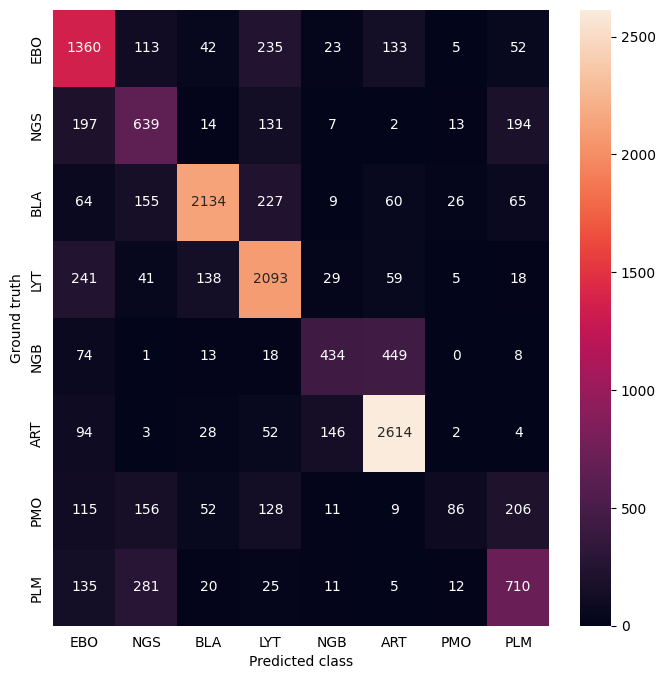

<Figure size 640x480 with 0 Axes>

In [110]:
visualize_cm(test_ds,loaded_model)
plt.savefig('/content/drive/MyDrive/cm.png')

In [38]:
def visualize_class_report(dataset,model):
    test_labels = []
    test_labels_=[]
    tests=[]
    preds_=[]
    for features, labels in dataset:
        test_labels.append(np.array(labels))
    for i in range(len(test_labels)):
        test_labels_.append(test_labels[i])
        for j in range(len(test_labels[i])):
            tests.append(np.argmax(test_labels[i][j]))
    for k in range(len(pred)):
        preds_.append(np.argmax(pred[k]))
            
    class_report = classification_report(tests, preds_)
    lines = class_report.split('\n')

    class_names =(list(class_dict.values()))
    data = [line.split()[1:] for line in lines[2:-3]]
    df = pd.DataFrame(data, columns=['precision', 'recall', 'f1-score', 'support'])
    df[['precision', 'recall', 'f1-score', 'support']] = df[['precision', 'recall', 'f1-score', 'support']].apply(pd.to_numeric)
    to_graph=df[:num_classes]
    sns.barplot(to_graph,x=class_names,y='f1-score',color='g')
    plt.xlabel('Classes')
    plt.ylabel('F1-score')
    # ax.tick_params(axis='x', bottom=False, labelbottom=True)
    plt.tick_params(axis='y', left=False, labelleft=True)
    plt.show()   

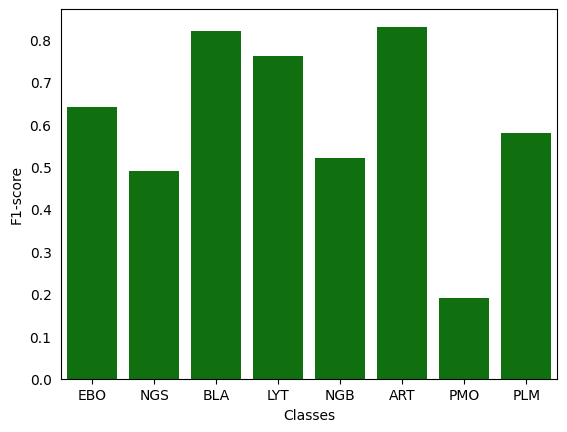

<Figure size 640x480 with 0 Axes>

In [92]:
visualize_class_report(test_ds,loaded_model)
plt.savefig('/content/drive/MyDrive/F1.png')

In [ ]:
# with open("/content/drive/MyDrive/cm_Drop_model.txt", "w") as file:
#     file.write(cm_Drop)

# # Download the file
# files.download("cm_Drop_model.txt")
[np.argmax(model.predict(image_pred))])  
-model.predict(image_pred)[np.argmax(model.predict(image_pred))])]  
class_dict [np.argmax(model.predict(image_pred)-np.max(model.predict(image_pred)))] 

In [108]:
### interpretability of predictions with lime
### function for Lime explanation of the test data

def get_image(idx):
    imag=data_df['image_path'].iloc[idx]
    Actual_class=data_df['label'].iloc[idx]
    image= cv2.imread(imag)
    image = cv2.resize(image, Img_res)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.
    image_pred=tf.expand_dims(image, axis=0)
    Predicted_class=class_dict[np.argmax(loaded_model.predict(image_pred))]             
    return [image,Predicted_class,Actual_class]
def get_interpret(idx):
    explainer = lime_image.LimeImageExplainer()
    image_,Predicted_class,Actual_class=get_image(idx)
    explanation = explainer.explain_instance(image_, loaded_model.predict, top_labels=5, hide_color=0, num_samples=200)

    # temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    print('Predicted class---',Predicted_class)
    print('Actual class---', Actual_class)
    if Actual_class==Predicted_class:
        print('Correctly Classified')
    else:
        print('---Missclassified---') 

### function for gatting the custom-loaded image for prediction
def get_external_image(image_pathway):
    image= cv2.imread(image_pathway)
    image = cv2.resize(image, Img_res)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.
    image_pred=tf.expand_dims(image, axis=0)
    Predicted_class=class_dict[np.argmax(loaded_model.predict(image_pred))]
    return [image,Predicted_class]
def get_interpret_custom(image_pathway):
    explainer = lime_image.LimeImageExplainer()
    image_,Predicted_class,Second_pred=get_image(image_pathway)
    explanation = explainer.explain_instance(image_, loaded_model.predict, top_labels=5, hide_color=0, num_samples=200)

                # temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
                # plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    print('Predicted class---',Predicted_class)
    
    

1/1 [==============================] - 0s 407ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
Predicted class--- BLA
Actual class--- EBO
---Missclassified---


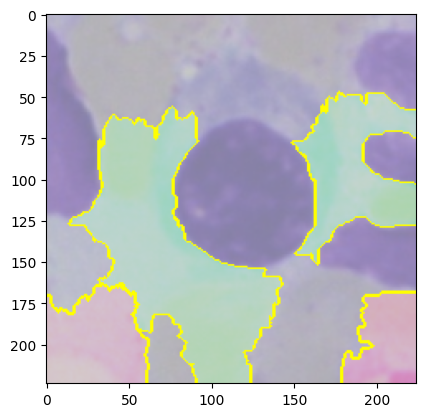

In [111]:
get_interpret(6)
plt.savefig('/content/drive/MyDrive/inter_5.png')

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/local.py", line 311, in __get__
    obj = instance._get_current_object()
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/local.py", line 508, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information about how to avoid this problem.


In [ ]:
### Deployment of the model in keras.Serving

model = load_model('/content/drive/MyDrive/checkpoints/model.h5')

# Define the endpoint URL
url = 'http://localhost:8501/v1/models/model:predict'  # Replace 'model_name' with your model's name

# Prepare the image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    image = cv2.imread(img)
    image_resized = cv2.resize(image, Img_res)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB) / 255.
    image_pred=tf.expand_dims(image, axis=0)
    
    return image_pred,image_rgb

# Make a prediction
def predict(image_path):
    image_pred,image_rgb = preprocess_image(image_path)
    payload = {
        'instances': [{model.layers[0].name: image_pred.tolist()}]  
    }
    explain=get_interpretation(image_path)
    response = requests.post(url, json=payload)
    predictions = response.json()['predictions']
    return predictions,



In [ ]:
# Example usage
image_path = 'path_to_your_image.jpg'
predictions = predict(image_path)
print(predictions)